# Programming Assignment No. 5: Random Forest
---

## Preparation

Import necessary libraries.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install -qU openpyxl

Load the dataset.

In [3]:
# Load the dataset
df = pd.read_excel('cyber_attacks.xlsx')
df.head()

,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,43.418651,1701.411601,201.794741,42,15,Botnet
1,1,8.587924,409.971403,710.745376,17,6,Normal
2,1,4.386891,418.478693,559.457816,17,5,Normal
3,0,NaN,NaN,NaN,11,3,Normal
4,0,1.061892,494.253699,572.459614,11,3,Normal


## Exploratory Data Analysis

In [4]:
df.shape # shape of the dataframe

(10000, 7)

In [5]:
attack_type_count = df.attack_type.value_counts() # distribution of labels
attack_type_count

attack_type
Normal      6000
Botnet      1000
DDoS        1000
Phishing    1000
PortScan    1000
Name: count, dtype: int64

---
The different types of attacks seem to be uniformly distributed except the normal type. It isn't usual to see this kind of perfectly uniform distribution for real world datasets but it is perfect for practicing machine learning. The Normal type and any other label that hints neutrality typically has more data points because it appears more than other labels. We should now see if there are any missing values and find ways to treat them.

---

### Missing Values

In [6]:
# Determine percentage of missing values

# missing values
missing_attack_type_count = df[df.isnull().any(axis=1)]['attack_type'].value_counts()

for attack_type in attack_type_count.index:
    total = attack_type_count[attack_type] # total missing per attack_type
    missing = missing_attack_type_count.get(attack_type, 0) # total missing per attack_type
    percent_missing = round(missing / total * 100, 2) # percent missing
    print(f"{attack_type}: {percent_missing}% missing")

Normal: 4.9% missing
Botnet: 5.7% missing
DDoS: 4.7% missing
Phishing: 5.6% missing
PortScan: 4.6% missing


---
We can see that almost 5% of the data are missing from each attack type. We can choose to simply remove these so as not to introduce any instability during training.

---

In [7]:
df_clean = df.dropna() # drop all rows with missing values
cleaned_count = df_clean.attack_type.value_counts() # final count
cleaned_count

attack_type
Normal      5706
PortScan     954
DDoS         953
Phishing     944
Botnet       943
Name: count, dtype: int64

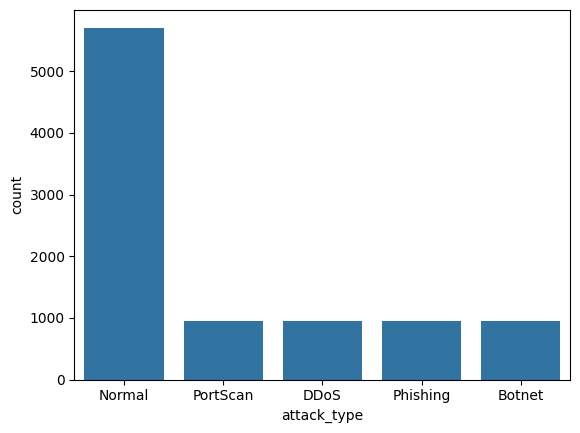

In [8]:
sns.barplot(cleaned_count);

---
We can see that we arrived with almost the same uniform distribution that we had earlier. The missing values may be another type of attack that the domain expert failed to categorize. Anyhow, it is beyond our work here and since we do not have any domain knowledge about cybersecurity attacks, we can safely choose to just remove these missing values. We can always perform a separate analysis of these missing values.

---

### Preprocessing

In [9]:
df_clean.dtypes # data types

protocol_type        int64
duration           float64
src_bytes          float64
dst_bytes          float64
num_packets          int64
num_connections      int64
attack_type         object
dtype: object

---
The `protocol_type` is a categorical feature represented as integers. This should be one-hot encoded such that the random forest classifier model wouldn't treat it as a numerical variable. It is often better that the categorical features be represented as embeddings such that the model don't assume numerical logical expressions.

---

In [10]:
# perform one-hot encoding to the protocol_type field
one_hot_encoding = pd.get_dummies(df_clean['protocol_type'], prefix='protocol')

# replace the said field with the one-hot encoding
df_encoded = pd.concat([one_hot_encoding, df_clean.drop(columns=['protocol_type'])], axis=1)

# rename the protocol_# fields
df_encoded.rename(columns={'protocol_0':'TCP', 'protocol_1':'UDP', 'protocol_2':'ICMP'}, inplace=True)
df_encoded.head()

,TCP,UDP,ICMP,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,False,True,False,43.418651,1701.411601,201.794741,42,15,Botnet
1,False,True,False,8.587924,409.971403,710.745376,17,6,Normal
2,False,True,False,4.386891,418.478693,559.457816,17,5,Normal
4,True,False,False,1.061892,494.253699,572.459614,11,3,Normal
5,True,False,False,30.718808,1471.686910,15.383583,40,19,Botnet


In [11]:
# Separate features and labels
x = df_encoded.drop(columns=['attack_type'])
y = df_encoded['attack_type']

# Split dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=69, stratify=y)

---
It is important that we stratify the dataset by the labels because even though non-normal attack types are distributed uniformly, normal attacks dominate the overall distribution. We need fair representation of these labels in the training set such that we can maximize the model performance across all labels.

---

## Model Training

Our goal is to identify the type of attack which is a categorical problem. We will be using the Random Forest classifier.

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# parameters for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
}
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def run_grid_search(param_grid, x_train, x_test, y_train, y_test):

    # random forest classifier
    rf = RandomForestClassifier(random_state=69)

    # define multiple scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_macro',
        'recall': 'recall_macro',
        'f1': 'f1_macro'
    }

    # run grid search with multiple scoring
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring=scoring,
        refit='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(x_train, y_train)  # fit the model

    # Best parameters and F1 score
    print("Best Parameters:", grid_search.best_params_)
    print("Best CV Accuracy Score:", grid_search.best_score_)

    # Evaluate on test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(x_test)
    
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print("Test Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Test Recall:", recall_score(y_test, y_pred, average='macro'))
    print("Test F1 Score:", f1_score(y_test, y_pred, average='macro'))

    return best_model

best_model = run_grid_search(param_grid, x_train, x_test, y_train, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Best CV Accuracy Score: 1.0
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1 Score: 1.0


---
We can see that the model that performed best is a Random Forest with no max depth and 100 trees. This reached a cross validation score of 1.0 and a test accuracy of 1.0. This may have been a case of overfitting but the data scientist think that the nature of data plays the biggest role why the accuracy is perfect. The data may have been synthetically generated and defined by hardcoded constraints or distribution. We could test the dataset to even smaller `n_estimators` since the grid search obtained the best score at the smallest value we provided. However, it already performed 100% in the test 

---

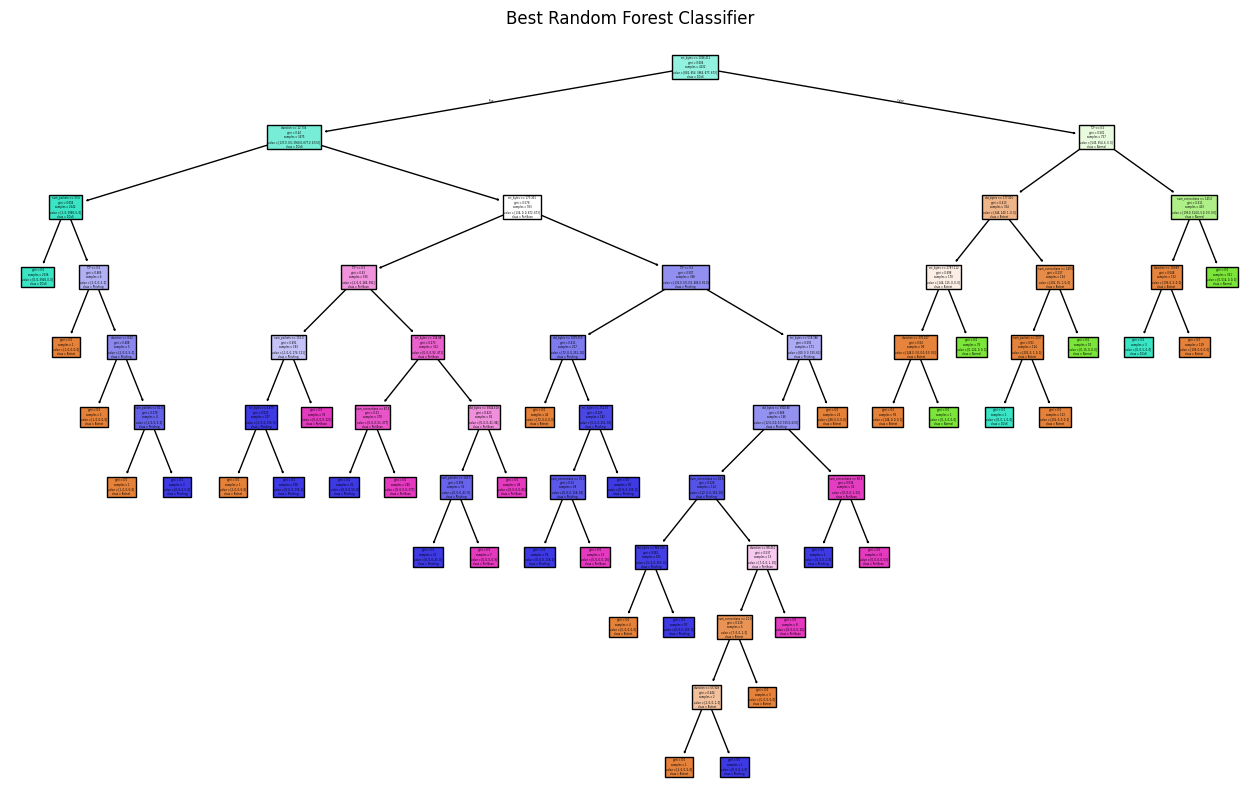

In [13]:
def visualize_tree(x, y, best_model, title):
    # Visualizing a single tree from Random Forest
    plt.figure(figsize=(16,10))
    
    # obtain the feature names and class names
    feature_names = x.columns.to_list()
    class_names = y.unique()
    
    # plot the best model from grid search
    plot_tree(decision_tree=best_model.estimators_[0], # Changed 'estimator=' to 'decision_tree='
              feature_names=feature_names,
              class_names=class_names,
              filled=True)
    plt.title(title)
    plt.show()

visualize_tree(x, y, best_model, 'Best Random Forest Classifier')

Feature Importances:
num_packets: 0.3045
num_connections: 0.2684
duration: 0.1671
dst_bytes: 0.1263
src_bytes: 0.1254
TCP: 0.0054
ICMP: 0.0025
UDP: 0.0003


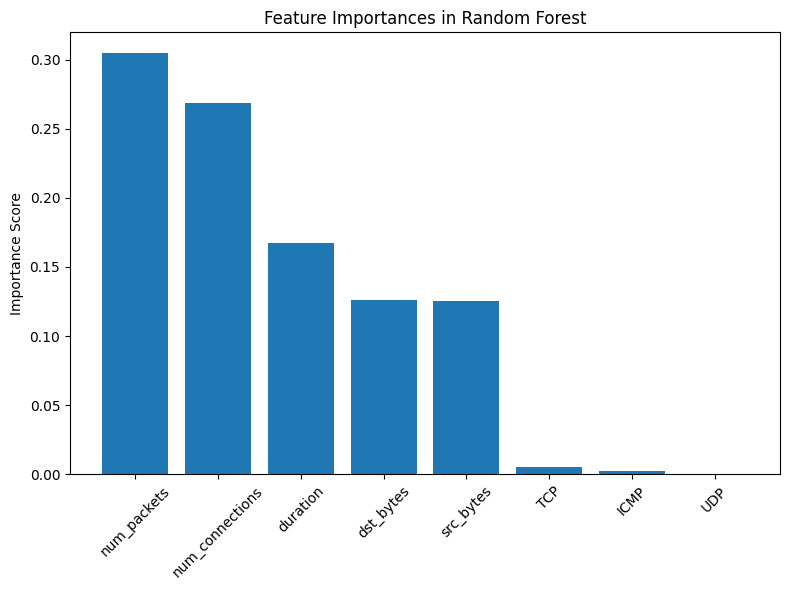

In [14]:
def plot_feature_importances(x, y, best_model, title):
    # obtain the feature names and class names
    feature_names = x.columns.to_list()
    class_names = y.unique()
    
    # Plot the feature importances
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    print("Feature Importances:")
    for idx in indices:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")
    
    # Visualize Feature Importance
    plt.figure(figsize=(8, 6))
    plt.title("Feature Importances in Random Forest")
    plt.bar(range(x.shape[1]), importances[indices], align="center")
    plt.xticks(range(x.shape[1]), [feature_names[i] for i in indices], rotation=45)
    plt.ylabel('Importance Score')
    plt.tight_layout()
    plt.show()

plot_feature_importances(x, y, best_model, 'Feature Importances in Random Forest')

---
We observed that TCP, ICMP, and UDP show very small feature importances. We can choose to remove this and apply the best model to reduce model complexity that may lead to overfitting. We can focus our interest on the other five features. By removing the one-hot encoded features we should also observe a shallower tree.

---

In [15]:
# Remove the protocol_type
x = df_clean.drop(columns=['attack_type', 'protocol_type'])
y = df_clean['attack_type']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=69, stratify=y)

best_model_no_protocol = run_grid_search(param_grid, x_train, x_test, y_train, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Best CV Accuracy Score: 1.0
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1 Score: 1.0


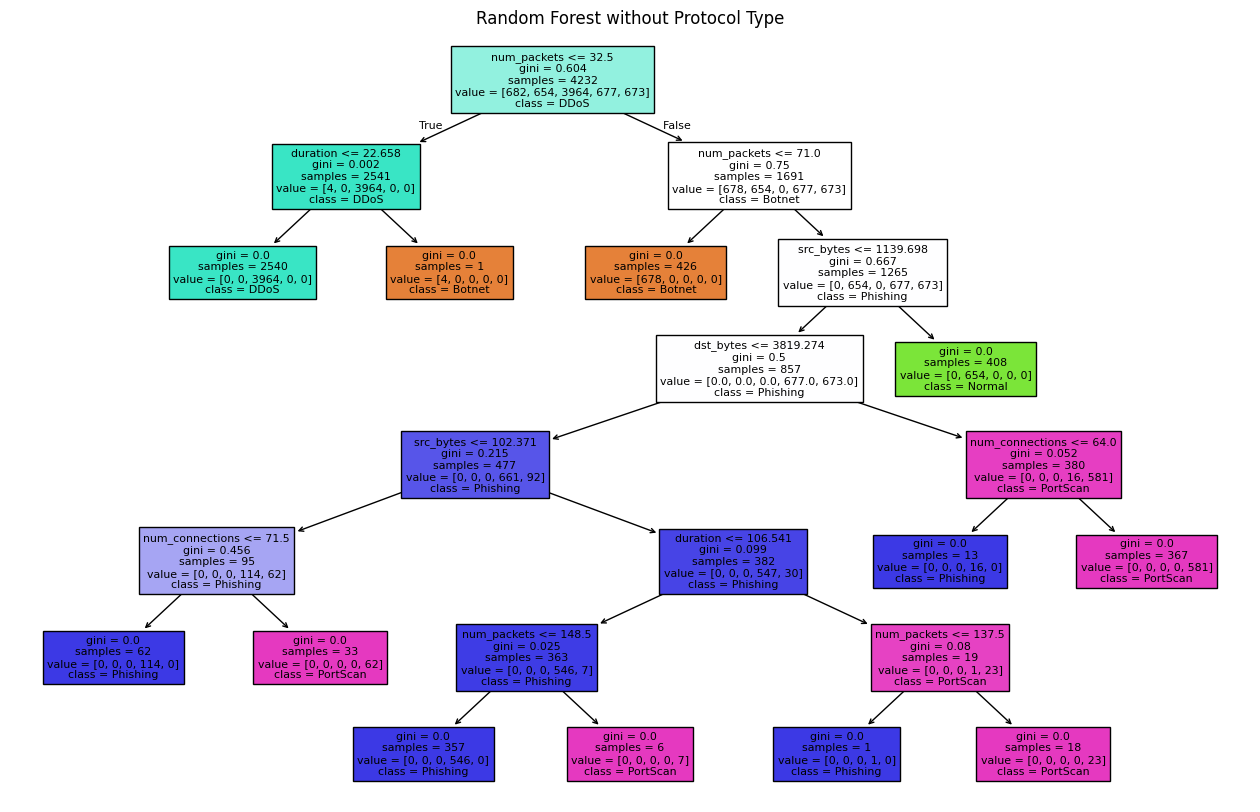

In [16]:
# visualize tree
visualize_tree(x, y, best_model_no_protocol, 'Random Forest without Protocol Type')

Feature Importances:
num_packets: 0.3782
num_connections: 0.2328
duration: 0.2073
dst_bytes: 0.1246
src_bytes: 0.0571


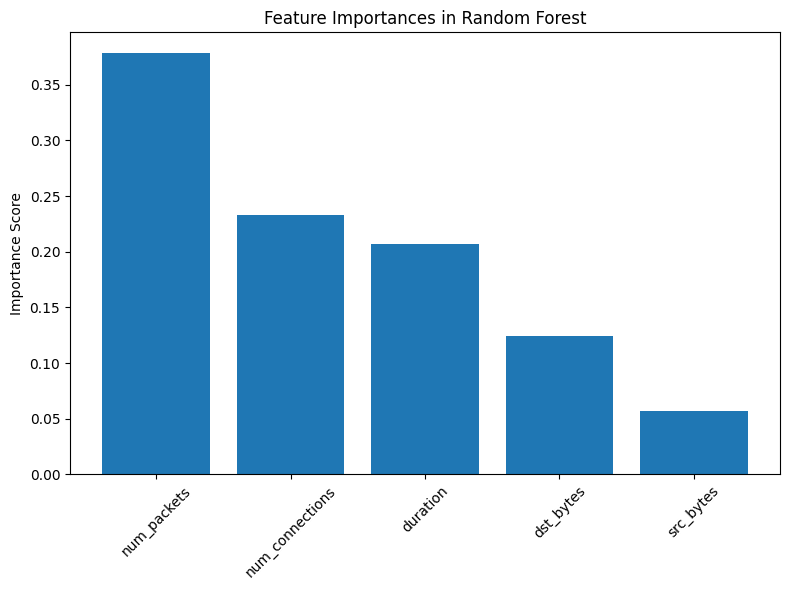

In [17]:
# plot feature importances
plot_feature_importances(x, y, best_model_no_protocol, 'Feature Importances without Protocol Type')

---
We can observe that the cross validation and test accuracy is still 1.0 by removing the `protocol_type` feature. This essentially reduces the model complexity and computational complexity by defining the tree across fewer features.

---

## Guide Questions

1. Preprocessing
    - How did you handle missing values in numerical features?<br>
    > We simply removed the missing values because in average only 5% of the data is missing per attack type. This maintained the distribution among the non-normal attack types. The missing values may be another type of attack that the domain expert failed to categorize. Anyhow, it is beyond our work here and since we do not have any domain knowledge about cybersecurity attacks, we can safely choose to just remove these missing values. We can always perform a separate analysis of these missing values.

    - Why is there a need to encode protocol_type feature, and which encoding method can be used?<br>
    > The protocol_type is a categorical feature represented as integers. This should be one-hot encoded so that the random forest classifier model wouldn't treat it as a numerical variable. It is often better that the categorical features be represented as embeddings such that the model don't assume numerical logical expressions for tree-based models.
  
      
2. Model Training
    - How did you address class imbalance in the dataset?<br>
    > There is a class imbalance between normal attack type and other attack types. This is, however, *normal* in real sense that neutral categories often have more data points. What we did is we stratified splitting the dataset across the labels such that both the training and testing sets have fair amount of data points per class.

    - What hyperparameters of the Random Forest did you tune, and why?<br>
    > We tuned `max_depth` and `n_estimators` because these are primary sensitive hyperparameters for tree-based models. What we planned on doing was to tune it with these first and if the model isn't good enough, we will add other hyperparameters to the mix. However, the model performed perfectly with these hyperparameters and we chose not to do further experimentation. The max depth determines the depth at which the tree can be formed while the number of estimators is the number of trees formed.

    - Why is a pipeline useful for this task?<br>
    > A pipeline can be useful for this task for one-hot encoding but we chose to do it a more straightforward way as recommended by pandas. One can create a pipeline that encodes the dataset and perform necessary preprocessing which could be beneficial if there are several preprocessing functions that the dataset will undergo. As per the lecture, tree-based models like Random Forest performs good even without scaling.

3. Evaluation
    - Why is accuracy alone insufficient to evaluate this model?<br>
    > Accuracy alone doesn't offer the whole picture to the analyst. Other metrics such as precision, recall, and especially F1-score must be considered. These metrics are important because there is an inherent imbalance in the dataset.

    - Which attack type was hardest to classify, and why might this be?<br>
    > Nothing. We handled the data well, stratified it, and perform evaluation metrics for all types. The model was able to perform good on every class. The data might be synthetically generated by hard coded constraints or distributions and the model was able to find it out.

    - How would you improve the model’s performance on minority classes?<br>
    > We should get more data for the minority classes, that's the primary solution. Without data, the model will fail to generalize and approximate the proper decisions in identifying minority classes. We can also perform the necessary steps we made in this laboratory such as stratification during splitting. Lastly, we can perform undersampling by removing data points from the normal category such that the model wouldn't fit too much to that. 

4. Interpretation
    - Which features were most important for classification? Does this align with real-world attack patterns?<br>
    > The feature importances ranked from most important is the number of packets, number of connections, duration, number of destination bytes, and number of source bytes. Based on basic cybersecurity attack knowledge of the analyst, this holds true to real-world attack patterns. The number of packets often show that there is an abnormal amount of data being communicated, the number of connections hint that there might be other nodes that listen to the requests, and the duration typically show traffic.

    - How would you explain the model’s decision-making process to a non-technical team?<br>
    > The model we used in this laboratory is an ensemble of decision trees called random forests. This model may be sensitive to overfitting or fail at generalization over other methods, it is the best model for observability which most models lack. The decision tree formed explicitly states the decisions it took the model to identify the proper type of attack and this can be readily translated for non-technical people.

5. Application
    - What steps would you take to deploy this model in a real-time network monitoring system?<br>
    > In deploying this model, we must create a pipeline to handle the preprocessing steps. Moreover, we can schedule training per incremental increase of newly created data points that are validated by the cybersecurity team. We can employ continuous model finetuning and deploy it in a CI/CD pipeline. A tool must be created to obtain the necessary features we used in training the model to be fed in the pipeline, along with a user interface that shows the prediction.

    - How would you handle new attack types not present in the training data?<br>
    > Handling new attack types fundamentally require data. We cannot assume that our model is able to characterize all other types of attack because this may result into a critical flaw in our system. However, we can do what we said from the last question, we can create a pipeline that would train the model again for every chunk of data. This should be rigidly outlined to the other teams because the model may assume a different kind of attack and cause errors. Errors like these are not simple errors because for every second an attacker gets hold of private data or resources translate into a business problem that may scale to large business or financial crisis.

GGs! Bang!